<a href="https://colab.research.google.com/github/aliu-7/Molecular-Property-Optimization-Algorithms/blob/main/Alex_Liu_Bayesian_Optimization_for_Molecular_Property_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install RDKit in Google Colab
!pip install rdkit

# Import necessary libraries
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
from google.colab import files
import io

# Load dataset
uploaded = files.upload()
print(uploaded.keys()) #verifying if getting a file error
data = pd.read_csv(io.BytesIO(uploaded['BACE_FEset_compounds_D3R_GC4 (5).csv']))


Saving BACE_FEset_compounds_D3R_GC4.csv to BACE_FEset_compounds_D3R_GC4 (5).csv
dict_keys(['BACE_FEset_compounds_D3R_GC4 (5).csv'])


In [ ]:
data.head()

,IDs,smiles,LogP,Molecular_Weight,TPSA
0,BACE_10,COCc1cc2cc(c1)C(=O)N[C@@H](C[C@H](C)CCOCCCCN2)...,4.84410,525.734,91.85
1,BACE_14,CC(C)c1cc(ccc1)C2(CC2)NC[C@@H](O)[C@@H]5Cc3cc(...,5.57800,569.746,99.69
2,BACE_48,C[C@@H]2CCOCCCCNc1cc(cc(C)n1)C(=O)N[C@@H](C2)[...,4.58942,543.753,121.54
3,BACE_49,CC(C)c3cccc(CNC[C@@H](O)[C@@H]2/C=C(\C)/CCOCCC...,4.66620,515.098,95.51
4,BACE_51,CC(C)c3cccc(CNC[C@@H](O)[C@@H]2C[C@H](C)CCCCCC...,5.86670,516.126,83.48


Each smiles represents a complex organic molecule, where the IDs are referencing them, and LogP represents how likely a molecule is to dissolve in fat (lipids) rather than water

In [ ]:
data.columns

Index(['IDs', 'smiles', 'LogP', 'Molecular_Weight', 'TPSA'], dtype='object')

In [ ]:
# Function to calculate LogP, Molecular Weight, and TPSA for each SMILES string, returning none if does not exist
def calculate_properties(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        logP = Descriptors.MolLogP(mol)
        mw = Descriptors.MolWt(mol)
        tpsa = Descriptors.TPSA(mol)
        return logP, mw, tpsa
    else:
        return None, None, None

# Apply the function to the SMILES column (SMILES contains complex organic molecules)
properties = data['smiles'].apply(calculate_properties)
data[['LogP', 'Molecular_Weight', 'TPSA']] = pd.DataFrame(properties.tolist(), index=data.index)


In [ ]:
# Select the target property for optimization (e.g., LogP)
target_property = 'LogP'  # Change to 'Molecular_Weight' or 'TPSA' as desire
x_range = np.linspace(-2*np.pi, 2*np.pi, 100)  # Adjust the range based on your specific goals

# Sample x values and outputs from the target property
sample_x = np.array(range(len(data)))
sample_y = data[target_property].values


In [ ]:
initial_x_values = np.array([0, 1, 2, 3])  # Replace this with your initial x values
initial_y_values = np.array([10, 20, 15, 18])  # Replace this with corresponding initial y values


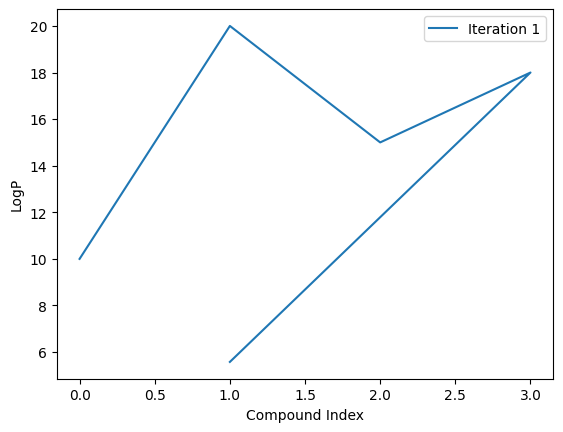

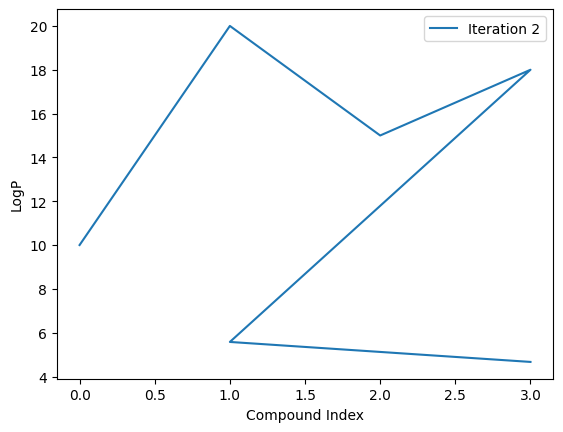

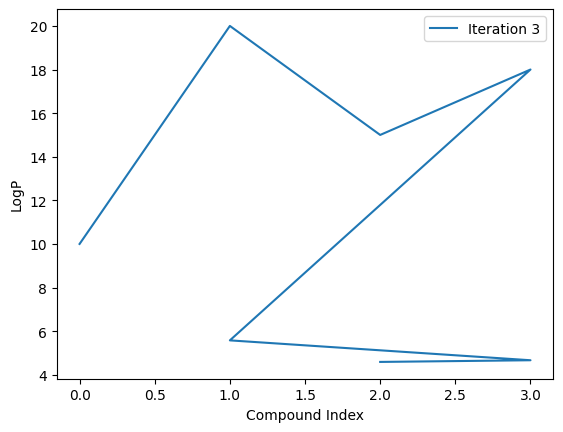

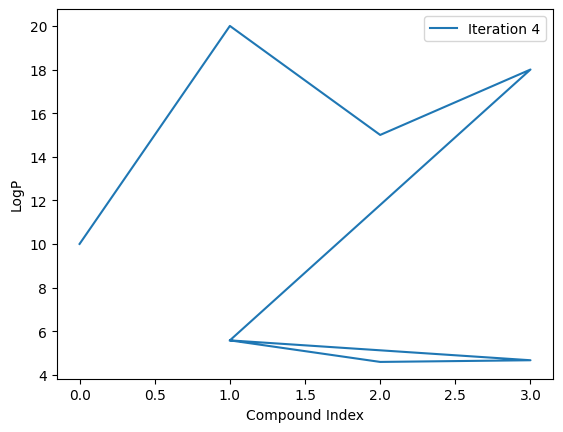

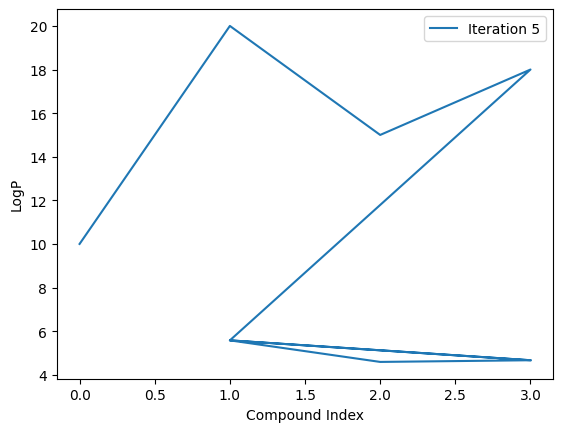

In [ ]:
def black_box_function(x):
    # Use the target property values directly
    return data[target_property].iloc[int(x)]  # Ensure x is an integer

def upper_confidence_bound(x, gp_model, beta):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    return y_pred + beta * y_std

# Initial setup for sample_x and sample_y
initial_x_values = np.array([0, 1, 2, 3])  # Example initial x values (replace with your actual initial values)
initial_y_values = np.array([10, 20, 15, 18])  # Corresponding initial y values (replace with your actual initial values)

sample_x = initial_x_values  # Initial sample_x values (ensure it is a 1D array)
sample_y = initial_y_values  # Corresponding initial sample_y values (same length as sample_x)

# Gaussian process with RBF kernel
kernel = RBF(length_scale=1.0)
gp_model = GaussianProcessRegressor(kernel=kernel)
num_iterations = 5

# Perform the optimization
for i in range(num_iterations):
    # Ensure sample_x and sample_y have the same length
    gp_model.fit(sample_x.reshape(-1, 1), sample_y)
    beta = 1.0 # change beta to lower exploration (lower value) or raise (higher value) to help the model focus more on exploiting the known best performing points
    ucb = upper_confidence_bound(sample_x, gp_model, beta)
    best_idx = np.argmax(ucb)

    # Append new data (ensure sample_x and sample_y stay the same length)
    new_x_value = sample_x[best_idx]  # Get the best value from sample_x
    new_y_value = black_box_function(new_x_value)  # Get the corresponding y value from the black box function

    # Append the new values to sample_x and sample_y
    sample_x = np.append(sample_x, new_x_value)
    sample_y = np.append(sample_y, new_y_value)

    # Plot the optimization progress for this iteration
    plt.plot(sample_x, sample_y, label=f"Iteration {i+1}")
    plt.xlabel("Compound Index")
    plt.ylabel(target_property)
    plt.legend()
    plt.show()  # Show the plot after each iteration


--------------------------------------------------------------------------------

Notes: Initially the optimizer selects points of high uncertainty around regions where the function is not well known. However, over time, the function converges towards regions of high prediction (exploitation) or continue exploring uncertain areas (exploration), which leads to the erract movements- sharp drops and movements to the left. Should try tweaking beta to make it better.

X-axis (Compound Index) is just indicating the index of the compound that I am testing

Y-axis (LogP) are the LogP values corresponding with the index... LogP tells how likely a molecule is to dissolve in fat (lipids) rather than water

Best LogP value: 5.578000000000005 at index 1


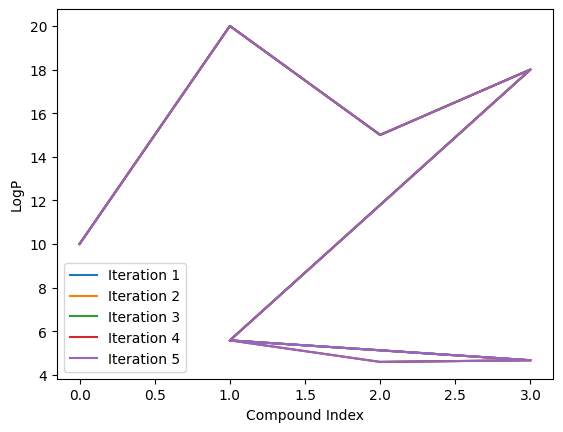

In [ ]:
t import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def black_box_function(x):
    # Use the target property values directly
    return data[target_property].iloc[int(x)]  # Ensure x is an integer

def upper_confidence_bound(x, gp_model, beta):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    return y_pred + beta * y_std

# Initial setup for sample_x and sample_y
initial_x_values = np.array([0, 1, 2, 3])  # Example initial x values (replace with your actual initial values)
initial_y_values = np.array([10, 20, 15, 18])  # Corresponding initial y values (replace with your actual initial values)

sample_x = initial_x_values  # Initial sample_x values (ensure it is a 1D array)
sample_y = initial_y_values  # Corresponding initial sample_y values (same length as sample_x)

# Gaussian process with RBF kernel
kernel = RBF(length_scale=1.0)
gp_model = GaussianProcessRegressor(kernel=kernel)
num_iterations = 5

# Variables to track the best index and LogP
best_logP_value = -np.inf  # Start with a very low value
best_index = -1  # To store the index of the best LogP value

# Perform the optimization
for i in range(num_iterations):
    # Ensure sample_x and sample_y have the same length
    gp_model.fit(sample_x.reshape(-1, 1), sample_y)
    beta = 2.0
    ucb = upper_confidence_bound(sample_x, gp_model, beta)
    best_idx = np.argmax(ucb)

    # Append new data (ensure sample_x and sample_y stay the same length)
    new_x_value = sample_x[best_idx]  # Get the best value from sample_x
    new_y_value = black_box_function(new_x_value)  # Get the corresponding y value from the black box function

    # Append the new values to sample_x and sample_y
    sample_x = np.append(sample_x, new_x_value)
    sample_y = np.append(sample_y, new_y_value)

    # Track the best LogP value and its index
    if new_y_value > best_logP_value:
        best_logP_value = new_y_value
        best_index = new_x_value  # Track the index of the best LogP value

    # Plot the optimization progress
    plt.plot(sample_x, sample_y, label=f"Iteration {i+1}")

# After all iterations, print the best index and LogP value
print(f"Best LogP value: {best_logP_value} at index {best_index}")

plt.xlabel("Compound Index")
plt.ylabel(target_property)
plt.legend()
plt.show()


Notes: Can use it for prediction by referencing specific indices in the blackbox function made to match the surrogate function - add note in the end of the chapter.

Also reference that this website (https://github.com/doyle-lab-ucla/edboplus/blob/main/examples/tutorials/1_CLI_example.ipynb) has a prebuilt library that skips the whole process if they just want applications for certain molecular property optimizations rather than custom ones.
